# Core 2 Artificial Neural Network

In this project, I will create a neural network that can classify Pokémon based using Tensorflow. <br>
I've used the following tutorial on Kaggle for the data and the model:

https://www.kaggle.com/code/shubhamptrivedi/pokemon-classification-model-using-tensorflow

I've used the following tutorial for the evaluation matrix:

https://www.v7labs.com/blog/confusion-matrix-guide



## EDA

### 1. Data Understanding

I will start with reading and Understanding the dataset

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

df_pokemon = pd.read_csv("pokemonANN.csv")
df_pokemon.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [2]:
#Check what data we have, their count and their data type
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    809 non-null    object
 1   Type1   809 non-null    object
 2   Type2   405 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB


In [3]:
#Check the shape of the dataset
df_pokemon.shape

(809, 3)

In [4]:
#Check unique values
df_pokemon.nunique()

Name     809
Type1     18
Type2     18
dtype: int64

### 2. Data Cleaning

Now I want to check if there are any empty columns and replace them with values

In [5]:
df_pokemon.isnull().values.any()

True

In [6]:
#Put the columns with null values in seperate variable and print it
cols_missing_val = df_pokemon.columns[df_pokemon.isnull().any()].tolist()
print(cols_missing_val)

['Type2']


In [7]:
#Count missing values in each column:
for col in cols_missing_val:
    print("%s : %d" % (col, df_pokemon[col].isnull().sum()))

Type2 : 404


In [8]:
#Unique values
df_pokemon['Type2'].unique()

array(['Poison', nan, 'Flying', 'Ground', 'Fairy', 'Grass', 'Fighting',
       'Psychic', 'Steel', 'Ice', 'Rock', 'Water', 'Electric', 'Fire',
       'Dragon', 'Dark', 'Ghost', 'Bug', 'Normal'], dtype=object)

Some values are missing in the Type2 Column. Not every pokemon has 2 characteristics. In this column I replace the empty values with 'hormann'.

In [9]:
#replace nan with new type2
df_pokemon['Type2'].fillna('hormann', inplace=True)

Now I'm going to check if all missing values are handled.

In [10]:
df_pokemon.isnull().values.any()

False

In [11]:
df_pokemon.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,hormann
4,charmeleon,Fire,hormann


### 3. Data Visualization

In this section, I want to start visualizing the data. I want to know which type is the most common in the dataset.

<AxesSubplot:>

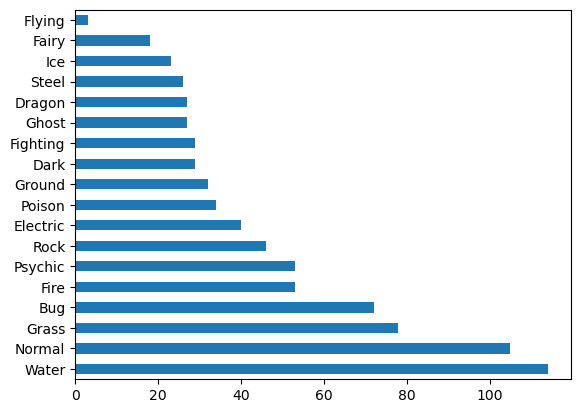

In [12]:
df_pokemon['Type1'].value_counts().plot(kind='barh')


<AxesSubplot:>

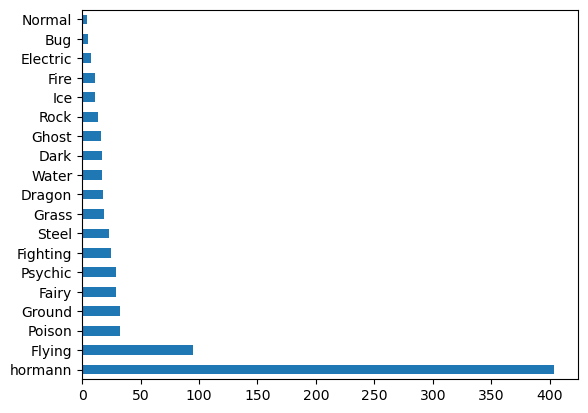

In [13]:
df_pokemon['Type2'].value_counts().plot(kind='barh')


Now, I'll add the pictures of the dataset.

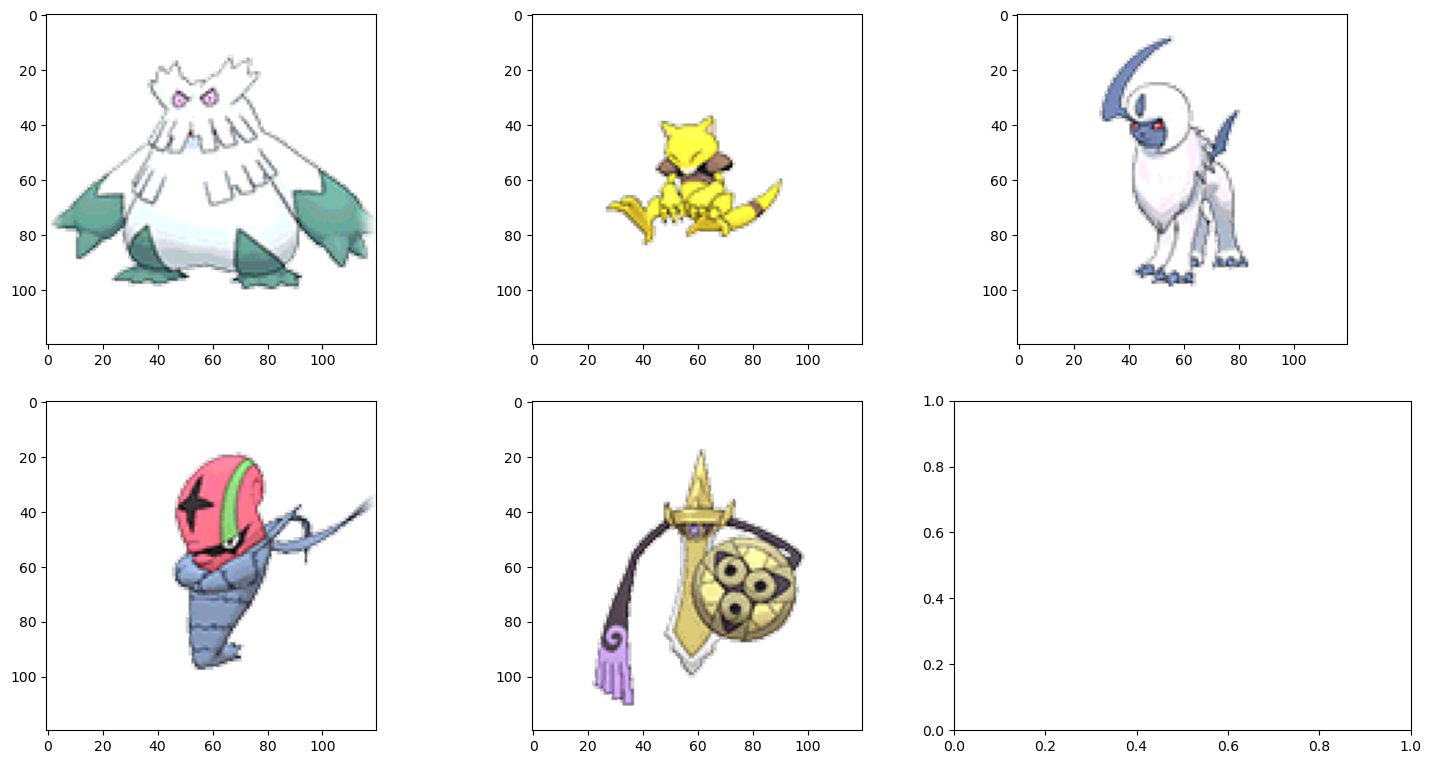

In [14]:
# defining root directory
from PIL import Image

root_dir = "images/images"

files =  os.path.join(root_dir)
File_names = os.listdir(files)

# plot here
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
first_five = File_names[0:6]

def subplots():
# Use the axes for plotting
    i = 0
    j = 0
    k = 0
    for k in range(5):
        state = os.path.join(root_dir, first_five[k])
        img = Image.open(state)
        axes[i,j].imshow(img)
        
        if k==2:
            i +=1
            j = 0
        else:
            j += 1


    plt.tight_layout(pad=2);
    
subplots()

We are going to use Type1 column as our labels. Each Name is unique and classified into 18 Type1 types.

In [15]:
data_dict = {}

for key, val in zip(df_pokemon["Name"], df_pokemon["Type1"]):
    data_dict[key] = val

## Preprocessing

In the preprocessing, I begin by tokenizing the types. This way, each type gets its own number. 

In [16]:
labels = df_pokemon["Type1"].unique()
print(labels)


['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']


In [17]:
ids = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
labels_idx = dict(zip(labels,ids))

print(labels_idx)

{'Grass': 0, 'Fire': 1, 'Water': 2, 'Bug': 3, 'Normal': 4, 'Poison': 5, 'Electric': 6, 'Ground': 7, 'Fairy': 8, 'Fighting': 9, 'Psychic': 10, 'Rock': 11, 'Ghost': 12, 'Ice': 13, 'Dragon': 14, 'Dark': 15, 'Steel': 16, 'Flying': 17}


In [18]:
import cv2

#Create two empty lists
final_images = []
final_labels = []

#initializes a count variable, which will be used to keep track of how many files have been processed.
count = 0
files =  os.path.join(root_dir)
for file in File_names:
    count += 1
    #read in an image file using the OpenCV library's cv2.imread() function.
    #The image is converted to grayscale using the cv2.COLOR_BGR2GRAY argument.
    img = cv2.imread(os.path.join(root_dir, file), cv2.COLOR_BGR2GRAY) 
    #assigns a label to the image based on its filename.
    label = labels_idx[data_dict[file.split(".")[0]]] 
    # append img in final_images list
    final_images.append(np.array(img))
    # append label in final_labels list
    final_labels.append(np.array(label))
    
    
# converting lists into numpy array
# normalizing and reshaping the data 
final_images = np.array(final_images, dtype = np.float32)/255.0
final_labels = np.array(final_labels, dtype = np.int8).reshape(809, 1)

## Model

I have segregated the data into images and labels, now I'm going to build the model in Tensorflow.

In [19]:
# import necessary libraries
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten


model = tf.keras.Sequential([
    # input layer, 2D array of shape (120, 120, 3) 
    # (representing a 120x120 image with 3 color channels).
    tf.keras.layers.Flatten(input_shape=(120, 120,3)),
    # fully connected layer with 100 nodes and a Rectified Linear Unit (ReLU) activation function. 
    # This layer is repeated three times.
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    # output layer, has 18 nodes 
    # (corresponding to the number of classes in the classification problem being addressed).
    tf.keras.layers.Dense(18)
])
# print model summary and check trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 43200)             0         
                                                                 
 dense (Dense)               (None, 100)               4320100   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 18)                1818      
                                                                 
Total params: 4,342,118
Trainable params: 4,342,118
Non-trainable params: 0
_________________________________________________________________


In this step, I'm going to train the neural network

In [20]:
# compile model (Use: Adam optimizer, categorical_crossentropy loss and metrics as Accuracy)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# fit model (use images and labels)
history = model.fit(final_images, final_labels, epochs=50)

Epoch 1/50
26/26 [==============================] - 1s 21ms/step - loss: 4.2570 - accuracy: 0.0902
Epoch 2/50
26/26 [==============================] - 1s 21ms/step - loss: 3.0161 - accuracy: 0.1533
Epoch 3/50
26/26 [==============================] - 1s 21ms/step - loss: 2.7074 - accuracy: 0.1990
Epoch 4/50
26/26 [==============================] - 1s 21ms/step - loss: 2.6427 - accuracy: 0.2398
Epoch 5/50
26/26 [==============================] - 1s 21ms/step - loss: 2.4511 - accuracy: 0.2633
Epoch 6/50
26/26 [==============================] - 1s 22ms/step - loss: 2.2626 - accuracy: 0.3473
Epoch 7/50
26/26 [==============================] - 1s 21ms/step - loss: 2.0434 - accuracy: 0.3844
Epoch 8/50
26/26 [==============================] - 1s 21ms/step - loss: 1.8513 - accuracy: 0.4400
Epoch 9/50
26/26 [==============================] - 1s 21ms/step - loss: 1.6379 - accuracy: 0.5031
Epoch 10/50
26/26 [==============================] - 1s 21ms/step - loss: 1.4715 - accuracy: 0.5426
Epoch 11/

## Evaluation Matrix

The last step is to Evaluate the model. I used the confusion matrix for this.

In [21]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(final_images)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(final_labels, y_pred_classes)
print(cm)


26/26 [==============================] - 0s 2ms/step
[[ 66   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  47   0   0   6   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 105   0   9   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  63   9   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 105   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   6  28   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   4   0  36   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0  30   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0  17   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   4   0   0   0   0  25   0   0   0   0   0   0   0   0]
 [  0   0   0   0   6   0   0   0   0   0  47   0   0   0   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0   0  41   0   0   0   0   0   0]
 [  0   0   0   0   4   0   0   0   0   0   0  

You have a total of 18 rows in this matrix. Each row represents its own label (the labels we gave to the pokemon types). <br>
The diagonal line in this case are the elements that are correctly predicted. <br>
The first element that has the label "Grass". Is thus correctly predicted 66 times and incorrectly predicted 12 times.

In [22]:
from sklearn.metrics import classification_report

report = classification_report(final_labels, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       1.00      0.85      0.92        78
           1       1.00      0.89      0.94        53
           2       1.00      0.92      0.96       114
           3       1.00      0.88      0.93        72
           4       0.58      1.00      0.73       105
           5       1.00      0.82      0.90        34
           6       1.00      0.90      0.95        40
           7       1.00      0.94      0.97        32
           8       1.00      0.94      0.97        18
           9       1.00      0.86      0.93        29
          10       1.00      0.89      0.94        53
          11       1.00      0.89      0.94        46
          12       1.00      0.85      0.92        27
          13       1.00      1.00      1.00        23
          14       1.00      0.89      0.94        27
          15       1.00      0.97      0.98        29
          16       1.00      0.85      0.92        26
          17       1.00    

Ultimately, I want to see how each label scores individually. I do this by creating a classification report.


In [26]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(final_images)

id = np.argmax(predictions[0])
print("\nid that we got from the model as prediction: {}\nType of pokemon associted with that id: {} ".format(id,labels[id]))
print("accuracy of the model",history.history['accuracy'][-1])

26/26 [==============================] - 0s 3ms/step

id that we got from the model as prediction: 0
Type of pokemon associted with that id: Grass 
accuracy of the model 0.8998764157295227


# The accuracy of the model ultimately 90 percent